# Minimizing the radius of an extremal EoS -- varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [1]:
# For measuring runtime
import time
start_time = time.time()

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint, quad
from astropy.constants import G, c
from numpy import pi
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import math
np.set_printoptions(threshold=sys.maxsize)
from scipy import optimize
from sympy import symbols, diff
import csv

In [3]:
# Using natural units
# 197 MeV * fm = 1
# 1 fm = 1 / (197 MeV)
# 3e8 m = 1 s
# 3e8 m / s = 1
# 1 J = 1 kg * (m / s)^2
# 1 J = 1 / 9e16 kg

natural = [(u.MeV, u.fm ** (-1), lambda fm_inverse: 1 / 197 * fm_inverse, lambda MeV: 197 * MeV),
           (u.m, u.s, lambda s: 1 / c.value * s, lambda m: c.value * m),
           (u.kg, u.J, lambda J: c.value ** 2 * J, lambda kg: 1 / c.value ** 2 * kg),
           (u.m / u.s, u.dimensionless_unscaled, lambda dimensionless: 1 / c.value * dimensionless, lambda v: c.value * v),
           (u.fm, u.MeV ** (-1), lambda MeV_inverse: 1 / 197 * MeV_inverse, lambda fm: 197 * fm)
          ]

G = (G.value * (1 * u.m / u.s).to(u.dimensionless_unscaled, equivalencies = natural) ** 2 * (1 * u.m).to(u.fm).to(1 / u.MeV, equivalencies = natural) / (1 * u.kg).to(u.J, equivalencies = natural).to(u.MeV))
G = G.value

## Functions to find numerical EoS arrays for Fermi gas and strong interaction given some number density (in natural units)

In [4]:
# Non-rest-mass energy E
def find_E(num_density):
    result = a * (num_density / n_0) ** alpha + b * (num_density / n_0) ** beta
    return result

# Energy density epsilon
def find_epsilon(num_density):
    E = find_E(num_density)
    result = num_density * (E + m_N)
    return result

# Chemical potential
def find_chem_potential(num_density):
    result = a * (alpha + 1) * (num_density / n_0) ** alpha + b * (beta + 1) * (num_density / n_0) ** beta + m_N
    return result

# Pressure
def find_pressure(num_density, epsilon_D, c_s_Upper):
    epsilon = find_epsilon(num_density)
    chem_potential = find_chem_potential(num_density)

    epsilon_Delta = epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
    
    num_density_c = num_density_from_energy_density(epsilon_c.value) * u.MeV ** 3
    chem_potential_c = find_chem_potential(num_density_c)
    pressure_c = - epsilon_c + chem_potential_c * num_density_c
    
    # Piece-wise extremal EoS
    if epsilon.value < epsilon_c.value:
        result = - epsilon + chem_potential * num_density    # Gandolfi nuclear EoS
    else:
        if epsilon.value < epsilon_Delta.value:
            result = pressure_c    # Flat EoS
        else:
            result = pressure_c + c_s_Upper * (epsilon - epsilon_Delta)    # EoS slope = c_s_Upper
    
    return result

In [5]:
# Finding number density as a function of energy density

def energy_density_minus_target_epsilon(n, target_epsilon):
    n = n * u.MeV ** 3
    result = find_epsilon(n).value - target_epsilon
    return result

def num_density_from_energy_density(epsilon):
    b = 10 ** 12
    if energy_density_minus_target_epsilon(0, epsilon) > 0:
        print(f"find_epsilon is {find_epsilon(0 * u.MeV ** 3)} and epsilon is {epsilon}.")
        return
    result = optimize.brentq(energy_density_minus_target_epsilon,
                             0,
                             b,
                             args = (epsilon,))
    return result

## Plotting the EoS

In [6]:
# epsilon = []
# pressure = []

# n = np.logspace(-0.3, 1, num = 200) * n_0

# for num_density in n:
#     epsilon_in_MeV = find_epsilon(num_density).value
#     epsilon_in_MeV_and_fm = epsilon_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     epsilon.append(epsilon_in_MeV_and_fm.value)
#     pressure_in_MeV = find_pressure(num_density, epsilon_D).value
#     pressure_in_MeV_and_fm = pressure_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     pressure.append(pressure_in_MeV_and_fm.value)

In [7]:
# fig, ax = plt.subplots(figsize = (8, 8))

# epsilon_c_MeV_and_fm = epsilon_c * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# epsilon_delta_MeV_and_fm = epsilon_delta * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# ax.set_title("Equation of state", fontsize = 15);
# ax.set_xlabel(r"$\mathrm{Energy\,density}\,\epsilon\,\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 15);
# ax.set_ylabel(r"$\mathrm{Pressure\,\left(MeV/\,fm^3\right)}$", fontsize = 15);
# ax.set_xlim(0, epsilon_delta_MeV_and_fm.value + 25);
# ax.set_ylim(0, 25);
# ax.plot(epsilon, pressure, label = "EoS");
# ax.axvline(x = epsilon_c_MeV_and_fm.value, color = "red", linewidth = 0.5, label = r"$\epsilon_{c}=150\,\mathrm{MeV/\,fm^3}$");
# ax.axvline(x = epsilon_delta_MeV_and_fm.value, color = "green", linewidth = 0.5, label = r"$\epsilon_{\Delta}=650\,\mathrm{MeV/\,fm^3}$");
# ax.legend(fontsize = 15);

# plt.savefig("Piecewise_EoS.pdf", bbox_inches = "tight");
# plt.savefig("Piecewise_EoS.jpg", bbox_inches = "tight");

## Generalized TOV

In [8]:
# r = distance from center
# m = cumulative mass enclosed within distance r from center
# p = pressure at distance r from center
# epsilon = energy density at distance r from center

# TOV coded to be compatible w/ cgs units, but can't explicitly give units in code b/c solve_ivp() throws errors

def TOV(r, p_and_m, epsilon_D, c_s_Upper):
    p = p_and_m[0]
    m = p_and_m[1]
    if num_density_from_pressure(p, r, epsilon_D, c_s_Upper) is None:
        return [0, 0]
    n = num_density_from_pressure(p, r, epsilon_D, c_s_Upper) * u.MeV ** 3
    epsilon = find_epsilon(n).value
    print(f"number density is {n}")
    rel_factors = (1 + p / epsilon) * (1 + 4 * pi * r ** 3 * p / m) * (1 - 2 * G * m / r) ** (-1)
    p_result = - G * epsilon * m / r ** 2 * rel_factors
    m_result = 4 * pi * r ** 2 * epsilon
    return [p_result, m_result]

In [9]:
# Finding number density as a function of pressure

def pressure_minus_target_p(n, target_p, epsilon_D, c_s_Upper):
    n = n * u.MeV ** 3
    result = find_pressure(n, epsilon_D, c_s_Upper).value - target_p
    return result

# Global variable so it can be modified when n_high needs to be increased later
pressure_brentq_b = 10 ** 8

def num_density_from_pressure(p, r, epsilon_D, c_s_Upper):
    if pressure_minus_target_p(0, p, epsilon_D, c_s_Upper) > 0:
        print(f"Distance from center is {(r / u.MeV).to(u.fm, equivalencies = natural).to(u.km)}, w/ find_pressure {find_pressure(0 * u.MeV ** 3, epsilon_D, c_s_Upper)} and p {p}.")
        return
        
    result = optimize.brentq(pressure_minus_target_p,
                             0,
                             pressure_brentq_b,
                             args = (p, epsilon_D, c_s_Upper))
    
    return result

### Setting central cumulative mass initial condition

In [10]:
def M_from_r_and_rho(r, rho):
    result = 4 * pi * rho * r ** 3 / 3
    return result

### TOV solver function

In [11]:
# Keep this for all EoS

def solve_TOV(n_central, p_central, epsilon_D, c_s_Upper):
    epsilon_central = find_epsilon(n_central * u.MeV ** 3).value
    m_central = M_from_r_and_rho(small_r, epsilon_central)
    
    def reached_surface(t, y, *args):
        return y[0]

    reached_surface.terminal = True
    reached_surface.direction = -1
    
    solution = solve_ivp(TOV,
                         [small_r, R_attempt],
                         [p_central, m_central],
                         events = reached_surface,
                         args = (epsilon_D, c_s_Upper)
                        )

    distance_from_center = (solution.t / u.MeV).to(u.fm, equivalencies = natural).to(u.km)
    print(f"Mass is {(solution.y[1][-1] * u. MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass):.3f}.")
    cumulative_mass = (solution.y[1] * u.MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass)
    pressure = solution.y[0]

    result = distance_from_center, cumulative_mass, pressure
    return result

### Setting constants for solving TOV

In [12]:
# Everything in natural units unless otherwise specified
# r_small cannot be 0 b/c it would cause a singularity.

small_r = (0.1 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value
m_N = 939.565 * u.MeV    # Natural units
n_0 = 0.16 / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3    # Nuclear saturation density

# Setting nuclear parameters (from Gandolfi et. al.)
a = 13.0 * u.MeV
alpha = 0.49
b = 3.21 * u.MeV
beta = 2.47

# Setting critical energy density corresponding to n_0 for piece-wise EoS
epsilon_c_value = 150    # In MeV / fm^3
epsilon_c = epsilon_c_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
# Note: need to specify epsilon_delta before solving TOV for piece-wise EoS

### Horizontal axis scale

In [13]:
# Everything in natural units unless otherwise specified

R_attempt = (100 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value

### Solving TOV example

In [14]:
# # Nuclear saturation number density is 0.16 fm^(-3)
# n_central = 7 * n_0
# print(f"{n_0:.3e}")
# p_central = find_pressure(n_central, epsilon_D).value
# print(f"p_central is {p_central}")
# distance_from_center, cumulative_mass, pressure = solve_TOV(n_central.value, p_central)

In [15]:
# fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

# ax1.set_title("Cumulative mass vs distance from center", fontsize = 18);
# ax1.set_xlabel("Distance from center (km)", fontsize = 18);
# ax1.set_ylabel(r"Cumulative mass ($\mathrm{M_{\odot}}$)", fontsize = 18);
# # ax1.set_xlim(0, 20);
# # ax1.set_ylim(0, 0.6);
# ax1.plot(distance_from_center, cumulative_mass);
# ax2.set_title("Pressure vs distance from center", fontsize = 18);
# ax2.set_xlabel("Distance from center (km)", fontsize = 18);
# ax2.set_ylabel(r"Pressure $\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 18);
# # ax2.set_xlim(0, 20);
# ax2.plot(distance_from_center, pressure);

In [16]:
# print(f"Mass is {np.max(cumulative_mass):.2f}.")

## Finding the minimum radius for a given EoS

In [17]:
# Function to find mass and radius for particular central number density and EoS parameters
def find_mass_radius(num_density, epsilon_D, c_s_Upper):
    # Solving TOV
    p_central = find_pressure(num_density, epsilon_D, c_s_Upper).value
    distance_from_center, cumulative_mass, _ = solve_TOV(num_density.value, p_central, epsilon_D, c_s_Upper)
    print(f"Solved TOV for epsilon_delta {epsilon_D} MeV / fm^3 and c_s_upper {c_s_Upper}")

    # Removing NaN and inf values
    cumulative_mass = cumulative_mass[~np.isnan(cumulative_mass)]
    cumulative_mass = cumulative_mass[~np.isinf(cumulative_mass)]

    # Picking out single values
    mass = cumulative_mass[-1].value
    radius = distance_from_center[-1].value
    
    return mass, radius

In [18]:
# Setting initial densities and default increment direction
n_low = n_0    # Undershoot
n_high = 8 * n_0    # Overshoot
direction = 1    # For low mass_high errors: +1 means increase, -1 means decrease

In [19]:
# Function to find the minimum radius for a given EoS -- 2 parameters, epsilon_delta and c_s_Upper
def find_min_radius(epsilon_D, c_s_Upper):
    # Stating global variables to allow modification
    global pressure_brentq_b
    
    # Creating empty masses, radius_candidates arrays to be populated
    masses = []
    radius_candidates = []

    # Creating initial array of central number densities
    n_exp_high = 1
    n_central = np.logspace(-0.1, n_exp_high, num = 50) * n_0
    
    for n_attempt in n_central:
        # Solving TOV
        mass, radius_candidate = find_mass_radius(n_attempt, epsilon_D, c_s_Upper)
        masses.append(mass)
        radius_candidates.append(radius_candidate)

    # Verifying that maximum mass is reached
    while np.max(masses) == masses[-1]:
        n_exp_high += 0.022
        n_attempt = 10 ** n_exp_high * n_0
        pressure_brentq_b += 10 ** 7.022    # Exactly the right amount
        mass, radius_candidate = find_mass_radius(n_attempt, epsilon_D, c_s_Upper)
        masses.append(mass)
        radius_candidates.append(radius_candidate)
        
    # Identifying minimum radius
    max_mass_index = np.argmax(masses)
    radius_candidates = radius_candidates[:max_mass_index + 1]
    min_radius_result = np.min(radius_candidates)
    
    # Recording minimum radius
    print(f"The minimum radius is {min_radius_result:.3f} km, while epsilon_delta is {epsilon_D:.3f} MeV / fm^3, and c_s_upper is {c_s_Upper:.3f}.")
    
    return min_radius_result

## Surveying minimum radius while varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [20]:
# Setting piece-wise EoS parameters to check
N = 6

epsilon_low = epsilon_c_value    # This would mean no flat segment
epsilon_high = epsilon_low * 10
epsilon_delta = np.linspace(epsilon_low, epsilon_high, N)

c_s_upper_low = 0.01
c_s_upper_high = 1
c_s_upper = np.linspace(c_s_upper_low, c_s_upper_high, N)

# Verifying value of energy density corresponding to n_high is greater than maximum epsilon_delta test value
# This is to ensure that the global maximum mass is not missed
epsilon_higher = find_epsilon(n_high).value * u.MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
if (epsilon_higher.value - epsilon_low) / (epsilon_high - epsilon_low) < 1.1:
    print(f"Error: The energy density corresponding to n_high -- {epsilon_higher:.2f} -- is too low.")
    epsilon_higher_ideal = 1.1 * (epsilon_high - epsilon_low) + epsilon_low
    print(f"epsilon_high is {epsilon_high:.2f} MeV / fm3, so the n_high energy density should be {epsilon_higher_ideal:.2f} MeV / fm3.")
    raise KeyboardInterrupt

In [ ]:
# Creating placeholder values for epsilon_delta_constraint and c_s_upper_constraint
epsilon_delta_constraint = epsilon_delta[0]
c_s_upper_constraint = c_s_upper[0]

# Creating placeholder value of min_radius
min_radius = 100

# Creating empty radii array to be populated during iterations
c_s_upper_size = np.size(c_s_upper)
epsilon_delta_size = np.size(epsilon_delta)
radii = np.zeros((c_s_upper_size, epsilon_delta_size))

# Opening csv file
with open("radius_minimization_2D.csv", "w") as outfile:
    data_writer = csv.writer(outfile)

    # Iterating through EoS parameter arrays to find minimum radii
    for i in range(epsilon_delta_size):
        epsilon_delta_value = epsilon_delta[i]
        
        for j in range(c_s_upper_size):
            c_s_upper_value = c_s_upper[j]
            radius_value = find_min_radius(epsilon_delta_value, c_s_upper_value)
            
            # Calculating runtime
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Elapsed time: {elapsed_time} seconds")
            
            data_writer.writerow([epsilon_delta_value, c_s_upper_value, radius_value, elapsed_time])
            radii[j][i] = radius_value

            # Identifying smallest value
            if radius_value < min_radius:
                min_radius = radius_value
                epsilon_delta_constraint = epsilon_delta_value
                c_s_upper_constraint = c_s_upper_value

number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237899 MeV3
number density is 971669.7022237857 MeV3
number density is 971669.7022237857 MeV3
number density is 971669.7022237853 MeV3
number density is 971669.7022237855 MeV3
number density i

In [28]:
epsilon_delta = [150.0, 1500.0]
c_s_upper = [0.01, 1.0]

radii = [[10.952606248098515, 11.451567018175092],
         [11.3331601753656, 4.698192983269555]
        ]

min_radius = 4.698192983269555
epsilon_delta_constraint = 1500.0
c_s_upper_constraint = 1.0

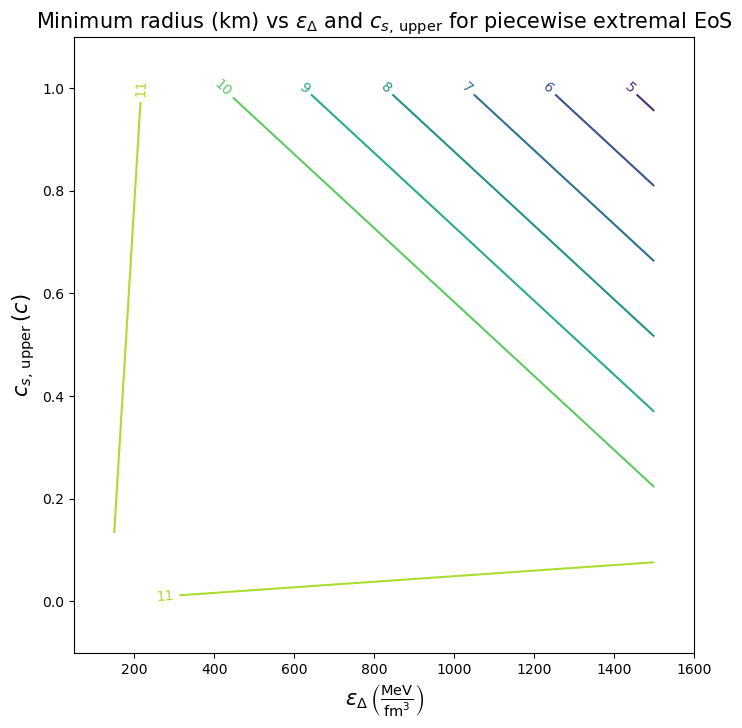

In [27]:
# Plotting minimum radius vs EoS parameters

fig, ax = plt.subplots(figsize = (8, 8))

ax.set_title(r"Minimum radius (km) vs $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$ for piecewise extremal EoS",
             fontsize = 15
            );

ax.set_xlabel(r"$\epsilon_{\Delta}\,\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$",
              fontsize = 15);

ax.set_ylabel(r"$c_{s,\,\mathrm{upper}}\,\left(c\right)$", fontsize = 15);
ax.set_xlim(50, 1600);
ax.set_ylim(-0.1, 1.1);
radius_contour = ax.contour(epsilon_delta, c_s_upper, radii);
ax.clabel(radius_contour);

# Saving plot if result is notable
plt.savefig("min_radius_vs_epsilon_delta_and_c_s_upper.jpg", bbox_inches = "tight");
plt.savefig("min_radius_vs_epsilon_delta_and_c_s_upper.pdf", bbox_inches = "tight");

In [29]:
# Adding units
epsilon_delta *= 1 * u.MeV / (1 * u.fm) ** 3
radii *= 1 * u.km

min_radius *= 1 * u.km
epsilon_delta_constraint *= 1 * u.MeV / (1 * u.fm) ** 3

In [30]:
# Displaying minimum radius and corresponding EoS parameters
print(f"The minimum radius is {min_radius:.3f}.")
print(f"The value of epsilon_delta that minimizes the radius is {epsilon_delta_constraint:.3f}.")
print(f"The value of c_s_upper that minimizes the radius is {c_s_upper_constraint:.3f}.")

The minimum radius is 4.698 km.
The value of epsilon_delta that minimizes the radius is 1500.000 MeV / fm3.
The value of c_s_upper that minimizes the radius is 1.000.


In [31]:
# Printing the results
print("radii:")
print(radii)
print("epsilon_delta:")
print(epsilon_delta)
print("c_s_upper:")
print(c_s_upper)

radii:
[[10.95260625 11.45156702]
 [11.33316018  4.69819298]] km
epsilon_delta:
[ 150. 1500.] MeV / fm3
c_s_upper:
[0.01, 1.0]


In [32]:
# Calculating runtime
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 21731.48455643654 seconds
